<a href="https://colab.research.google.com/github/shahriariit/Autism-Face-Recognition/blob/master/Implementing_Active_Learning_on_Supplementary_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# importing basic libraries
import pandas as pd
import numpy as np

# visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# preprocessing libraries
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer

# feature selection
from sklearn.feature_selection import SelectKBest, mutual_info_classif, mutual_info_regression, f_regression, RFE, SequentialFeatureSelector # Removed PermutationImportance from here
from sklearn.inspection import permutation_importance # Import PermutationImportance from sklearn.inspection

# models
#import shap
import xgboost as xgb
#from lime.lime_tabular import LimeTabularExplainer
from sklearn.pipeline import make_pipeline
from collections import defaultdict
# machine learning models
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, Ridge,  Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, GradientBoostingRegressor, ExtraTreesRegressor, StackingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score

# model tunning
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# evaluation metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score, mean_absolute_percentage_error
from scipy.stats import zscore

# warnings
import warnings
warnings.filterwarnings('ignore')


In [ ]:
# load the data
df = pd.read_csv('https://raw.githubusercontent.com/muajnstu/Implementation-of-Active-Learning-Method-in-Regression-Model/refs/heads/main/Supplementary%20dataset.csv')

In [ ]:
#Log-transform the target variable

#df['PremiumPrice'] = np.log1p(df['PremiumPrice'])

In [ ]:
df.head()

,Age,Diabetes,BloodPressureProblems,AnyTransplants,AnyChronicDiseases,Height,Weight,KnownAllergies,HistoryOfCancerInFamily,NumberOfMajorSurgeries,PremiumPrice
0,45,0,0,0,0,155,57,0,0,0,25000
1,60,1,0,0,0,180,73,0,0,0,29000
2,36,1,1,0,0,158,59,0,0,1,23000
3,52,1,1,0,1,183,93,0,0,2,28000
4,38,0,0,0,1,166,88,0,0,1,23000


In [ ]:
X=df.drop('PremiumPrice',axis=1)
y=df['PremiumPrice']

In [ ]:
def mutual_info_feature_selection(X, y, k=5):

    selector = SelectKBest(score_func=mutual_info_regression, k=k)
    X_selected = selector.fit_transform(X, y)
    selected_features = X.columns[selector.get_support()]

    print(f"Selected features using mutual_info_regression: {selected_features.tolist()}")
    return selected_features.tolist(), X_selected


def sequential_feature_selection(X, y, k=5, direction='forward'):

    model = RandomForestRegressor(random_state=42)
    selector = SequentialFeatureSelector(
        estimator=model,
        n_features_to_select=k,
        direction=direction,
        scoring='r2',
        cv=5,
        n_jobs=-1
    )
    selector.fit(X, y)
    selected_features = X.columns[selector.get_support()]
    X_selected = selector.transform(X)

    print(f"Selected features using SFS ({direction}): {selected_features.tolist()}")
    return selected_features.tolist(), X_selected


def rfe_feature_selection(X, y, k=7, estimator=None):

    if estimator is None:
        estimator = RandomForestRegressor(random_state=42)

    selector = RFE(estimator, n_features_to_select=k)
    selector.fit(X, y)
    selected_features = X.columns[selector.get_support()]
    X_selected = selector.transform(X)

    print(f"Selected features using RFE: {selected_features.tolist()}")
    return selected_features.tolist(), X_selected


def permutation_importance_selection(X, y, k=3, estimator=None, scoring='r2', n_repeats=10, random_state=42):

    if estimator is None:
        estimator = RandomForestRegressor(random_state=random_state)

    estimator.fit(X, y)
    result = permutation_importance(estimator, X, y, scoring=scoring, n_repeats=n_repeats, random_state=random_state)

    importance_df = pd.DataFrame({
        'feature': X.columns,
        'importance_mean': result.importances_mean
    }).sort_values(by='importance_mean', ascending=False)

    selected_features = importance_df['feature'].head(k).tolist()
    X_selected = X[selected_features].values

    print(f"Selected features using permutation importance: {selected_features}")
    return selected_features, X_selected



def minmax_scaler_func(df, numerical_features):
    minmax_scaler = MinMaxScaler()

    # Create a copy to avoid modifying the original DataFrame
    df_minmax_scaled = df.copy()

    df_minmax_scaled[numerical_features] = minmax_scaler.fit_transform(df[numerical_features])
    return df_minmax_scaled

def standard_scaler_func(df, numerical_features):
    standard_scaler = StandardScaler()

    # Create a copy to avoid modifying the original DataFrame
    df_standard_scaled = df.copy()

    df_standard_scaled[numerical_features] = standard_scaler.fit_transform(df[numerical_features])
    return df_standard_scaled

def log_transformer_func(df, numerical_features):
    # Create a copy to avoid modifying the original DataFrame
    df_log_transformed = df.copy()
    # Apply log1p transformation (log(1 + x)) to handle potential zero values
    df_log_transformed[numerical_features] = np.log1p(df[numerical_features])
    return df_log_transformed

In [ ]:
numerical_features = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
df_scaled = standard_scaler_func(df, numerical_features)
df_minmax = minmax_scaler_func(df, numerical_features)
df_log = log_transformer_func(df, numerical_features)

In [ ]:
selected_features_fs1, _ = mutual_info_feature_selection(X, y, k=5)
df_fs1 = pd.concat([X[selected_features_fs1], y], axis=1)

selected_features_fs2, _ = sequential_feature_selection(X, y, k=5, direction='forward')
df_fs2 = pd.concat([X[selected_features_fs2], y], axis=1)

selected_features_fs3, _ = rfe_feature_selection(X, y, k=7)
df_fs3 = pd.concat([X[selected_features_fs3], y], axis=1)

selected_features_fs4, _ = permutation_importance_selection(X, y, k=5)
df_fs4 = pd.concat([X[selected_features_fs4], y], axis=1)

Selected features using mutual_info_regression: ['Age', 'AnyTransplants', 'AnyChronicDiseases', 'Weight', 'NumberOfMajorSurgeries']
Selected features using SFS (forward): ['Age', 'AnyTransplants', 'AnyChronicDiseases', 'Weight', 'NumberOfMajorSurgeries']
Selected features using RFE: ['Age', 'AnyTransplants', 'AnyChronicDiseases', 'Height', 'Weight', 'HistoryOfCancerInFamily', 'NumberOfMajorSurgeries']
Selected features using permutation importance: ['Age', 'AnyTransplants', 'Weight', 'AnyChronicDiseases', 'NumberOfMajorSurgeries']


In [ ]:
# Identify numerical features within the selected sets + target
numerical_features_fs1 = [col for col in selected_features_fs1 + ['PremiumPrice'] if col in df_fs1.select_dtypes(include=np.number).columns]
numerical_features_fs2 = [col for col in selected_features_fs2 + ['PremiumPrice'] if col in df_fs2.select_dtypes(include=np.number).columns]
numerical_features_fs3 = [col for col in selected_features_fs3 + ['PremiumPrice'] if col in df_fs3.select_dtypes(include=np.number).columns]
numerical_features_fs4 = [col for col in selected_features_fs4 + ['PremiumPrice'] if col in df_fs4.select_dtypes(include=np.number).columns]


df_fs1_minmax = minmax_scaler_func(df_fs1, numerical_features_fs1)
df_fs2_minmax = minmax_scaler_func(df_fs2, numerical_features_fs2)
df_fs3_minmax = minmax_scaler_func(df_fs3, numerical_features_fs3)
df_fs4_minmax = minmax_scaler_func(df_fs4, numerical_features_fs4)

# %%
df_fs1_scaled = standard_scaler_func(df_fs1, numerical_features_fs1)
df_fs2_scaled = standard_scaler_func(df_fs2, numerical_features_fs2)
df_fs3_scaled = standard_scaler_func(df_fs3, numerical_features_fs3)
df_fs4_scaled = standard_scaler_func(df_fs4, numerical_features_fs4)

# Implementing Active Learning

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_idx = y_true != 0
    return np.mean(np.abs((y_true[non_zero_idx] - y_pred[non_zero_idx]) / y_true[non_zero_idx])) * 100

In [ ]:

def run_active_learning(
    df, target_col="PremiumPrice", initial_samples=200, query_size=20, iterations=20
):

    # Split into features and target
    X = df.drop(columns=target_col)
    y = df[target_col]

    # Split into training and testing
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Step 2: Define models
    models = {
        "Linear Regression": LinearRegression(),
        "Extra Trees Regressor": ExtraTreesRegressor(n_estimators=100, random_state=42),
        "SVR": SVR(kernel='linear'),
        "KNN Regressor": KNeighborsRegressor(
            n_neighbors=15,
            p=1,
            weights='distance'
        ),

        "XGBoost Regressor": XGBRegressor(
            n_estimators=100, random_state=42, verbosity=0
        ),
        "Bagging Regressor": BaggingRegressor(n_estimators=10, random_state=42),
        "Ridge Regression": Ridge(alpha=1.0),
        "Gradient Boosting": GradientBoostingRegressor(),
        "Random Forest": RandomForestRegressor(random_state=42),
        "Stacked Model": StackingRegressor(
            estimators=[
                ("ridge", Ridge()),
                ("rf", RandomForestRegressor()),
            ],
            final_estimator=GradientBoostingRegressor(),
        ),
        #"Lasso Regression": Lasso(alpha=1.0),
        #"Elastic Net": ElasticNet(alpha=1.0, l1_ratio=0.5),
        "CART Regressor": DecisionTreeRegressor(
        max_depth=None,
        max_features=None,
        min_samples_leaf=2,
        min_samples_split=20,
        random_state=42
    ),

    }

    results = {}

    for name, model in models.items():
        print(f"\nRunning Active Learning for {name}")
        # Step 3: Initial labeled and unlabeled split
        X_train_shuffled, y_train_shuffled = shuffle(
            X_train, y_train, random_state=42
        )
        X_labeled = pd.DataFrame(X_train_shuffled[:initial_samples])
        y_labeled = pd.Series(y_train_shuffled[:initial_samples])
        X_unlabeled = pd.DataFrame(X_train_shuffled[initial_samples:])
        y_unlabeled = pd.Series(y_train_shuffled[initial_samples:])

        for i in range(iterations):
            # Convert data to NumPy arrays for consistency
            X_labeled_np = X_labeled.values
            y_labeled_np = y_labeled.values
            X_unlabeled_np = X_unlabeled.values
            X_test_np = X_test.values

            # Step 4: Train the model on labeled data
            model.fit(X_labeled_np, y_labeled_np)
            predictions = model.predict(X_unlabeled_np)

            # Step 5: Uncertainty sampling (variance-based if supported by the model)
            if hasattr(model, "estimators_"):  # For ensemble models like RandomForest
                if isinstance(model, GradientBoostingRegressor):
                    # For GradientBoostingRegressor, estimators_ is a 2D array of (n_estimators, 1)
                    pred_ensemble = np.array(
                        [tree[0].predict(X_unlabeled_np) for tree in model.estimators_]
                    )
                else:
                    # For models like RandomForest and ExtraTrees
                    pred_ensemble = np.array(
                        [estimator.predict(X_unlabeled_np) for estimator in model.estimators_]
                    )
                uncertainty = np.var(pred_ensemble, axis=0)
            else:
                # Placeholder for other models
                uncertainty = np.abs(predictions)

            # Select the most uncertain samples
            uncertain_idx = np.argsort(uncertainty)[-query_size:]

            # Move the most uncertain samples from unlabeled to labeled
            X_new = X_unlabeled.iloc[uncertain_idx]
            y_new = y_unlabeled.iloc[uncertain_idx]

            X_labeled = pd.concat([X_labeled, X_new])
            y_labeled = pd.concat([y_labeled, y_new])
            X_unlabeled = X_unlabeled.drop(X_new.index)
            y_unlabeled = y_unlabeled.drop(y_new.index)

            # Step 6: Evaluate model performance
            y_pred = model.predict(X_test_np)
            mse = mean_squared_error(y_test, y_pred)
            rmse = np.sqrt(mse)
            mae = mean_absolute_error(y_test, y_pred)
            mape = mean_absolute_percentage_error(y_test, y_pred)
            r2 = r2_score(y_test, y_pred)
            n, k = X_test.shape
            adjusted_r2 = 1 - ((1 - r2) * (n - 1) / (n - k - 1))
            evs = explained_variance_score(y_test, y_pred) # Calculate EVS

            print(
                f"Iteration {i + 1}: MAE = {mae:.3f}, RMSE = {rmse:.3f}, R² = {r2:.3f}, Adjusted R² = {adjusted_r2:.3f}, EVS = {evs:.3f},MAPE = {mape:.3f} "
            )

            # Stop if no more unlabeled data is available
            if X_unlabeled.empty:
                break

        # Final evaluation
        y_pred_final = model.predict(X_test_np)
        mse_final = mean_squared_error(y_test, y_pred_final)
        rmse_final = np.sqrt(mse_final)
        mae_final = mean_absolute_error(y_test, y_pred_final)
        mape_final = mean_absolute_percentage_error(y_test, y_pred_final)
        r2_final = r2_score(y_test, y_pred_final)
        adjusted_r2_final = 1 - ((1 - r2_final) * (n - 1) / (n - k - 1))
        evs_final = explained_variance_score(y_test, y_pred_final) # Calculate EVS

        results[name] = {
            "Final MAE": mae_final,
            "Final RMSE": rmse_final,
            "Final R²": r2_final,
            "Final Adjusted R²": adjusted_r2_final,
            "Final EVS": evs_final, # Include EVS in results
            "Final MAPE": mape_final,
        }

    # Final summary
    print("\nModel Comparison After Active Learning:")
    for name, metrics in results.items():
        print(
            f"{name}: Final MAE = {metrics['Final MAE']:.3f}, Final RMSE = {metrics['Final RMSE']:.3f}, "
            f"Final R² = {metrics['Final R²']:.3f}, Final Adjusted R² = {metrics['Final Adjusted R²']:.3f}, "
            f"Final EVS = {metrics['Final EVS']:.3f},  Final MAPE = {metrics['Final MAPE']:.3f}" # Print EVS in summary
        )

    return results

In [ ]:
result=run_active_learning(df)


Running Active Learning for Linear Regression
Iteration 1: MAE = 2701.523, RMSE = 3598.915, R² = 0.696, Adjusted R² = 0.680, EVS = 0.697,MAPE = 12.073 
Iteration 2: MAE = 2819.176, RMSE = 3700.239, R² = 0.679, Adjusted R² = 0.662, EVS = 0.680,MAPE = 12.681 
Iteration 3: MAE = 2766.310, RMSE = 3640.478, R² = 0.689, Adjusted R² = 0.673, EVS = 0.690,MAPE = 12.362 
Iteration 4: MAE = 2786.730, RMSE = 3677.365, R² = 0.683, Adjusted R² = 0.666, EVS = 0.684,MAPE = 12.537 
Iteration 5: MAE = 2771.109, RMSE = 3665.223, R² = 0.685, Adjusted R² = 0.668, EVS = 0.686,MAPE = 12.457 
Iteration 6: MAE = 2792.393, RMSE = 3679.966, R² = 0.682, Adjusted R² = 0.665, EVS = 0.684,MAPE = 12.539 
Iteration 7: MAE = 2786.569, RMSE = 3678.894, R² = 0.683, Adjusted R² = 0.666, EVS = 0.684,MAPE = 12.493 
Iteration 8: MAE = 2789.381, RMSE = 3680.098, R² = 0.682, Adjusted R² = 0.665, EVS = 0.683,MAPE = 12.561 
Iteration 9: MAE = 2784.444, RMSE = 3678.151, R² = 0.683, Adjusted R² = 0.666, EVS = 0.683,MAPE = 12.487 

In [ ]:
result=run_active_learning(df_minmax)


Running Active Learning for Linear Regression
Iteration 1: MAE = 2701.523, RMSE = 3598.915, R² = 0.696, Adjusted R² = 0.680, EVS = 0.697,MAPE = 12.073 
Iteration 2: MAE = 2819.176, RMSE = 3700.239, R² = 0.679, Adjusted R² = 0.662, EVS = 0.680,MAPE = 12.681 
Iteration 3: MAE = 2766.310, RMSE = 3640.478, R² = 0.689, Adjusted R² = 0.673, EVS = 0.690,MAPE = 12.362 
Iteration 4: MAE = 2786.730, RMSE = 3677.365, R² = 0.683, Adjusted R² = 0.666, EVS = 0.684,MAPE = 12.537 
Iteration 5: MAE = 2771.109, RMSE = 3665.223, R² = 0.685, Adjusted R² = 0.668, EVS = 0.686,MAPE = 12.457 
Iteration 6: MAE = 2792.393, RMSE = 3679.966, R² = 0.682, Adjusted R² = 0.665, EVS = 0.684,MAPE = 12.539 
Iteration 7: MAE = 2786.569, RMSE = 3678.894, R² = 0.683, Adjusted R² = 0.666, EVS = 0.684,MAPE = 12.493 
Iteration 8: MAE = 2789.381, RMSE = 3680.098, R² = 0.682, Adjusted R² = 0.665, EVS = 0.683,MAPE = 12.561 
Iteration 9: MAE = 2784.444, RMSE = 3678.151, R² = 0.683, Adjusted R² = 0.666, EVS = 0.683,MAPE = 12.487 

In [ ]:
result=run_active_learning(df_scaled)


Running Active Learning for Linear Regression
Iteration 1: MAE = 2701.523, RMSE = 3598.915, R² = 0.696, Adjusted R² = 0.680, EVS = 0.697,MAPE = 12.073 
Iteration 2: MAE = 2819.176, RMSE = 3700.239, R² = 0.679, Adjusted R² = 0.662, EVS = 0.680,MAPE = 12.681 
Iteration 3: MAE = 2766.310, RMSE = 3640.478, R² = 0.689, Adjusted R² = 0.673, EVS = 0.690,MAPE = 12.362 
Iteration 4: MAE = 2786.730, RMSE = 3677.365, R² = 0.683, Adjusted R² = 0.666, EVS = 0.684,MAPE = 12.537 
Iteration 5: MAE = 2771.109, RMSE = 3665.223, R² = 0.685, Adjusted R² = 0.668, EVS = 0.686,MAPE = 12.457 
Iteration 6: MAE = 2792.393, RMSE = 3679.966, R² = 0.682, Adjusted R² = 0.665, EVS = 0.684,MAPE = 12.539 
Iteration 7: MAE = 2786.569, RMSE = 3678.894, R² = 0.683, Adjusted R² = 0.666, EVS = 0.684,MAPE = 12.493 
Iteration 8: MAE = 2789.381, RMSE = 3680.098, R² = 0.682, Adjusted R² = 0.665, EVS = 0.683,MAPE = 12.561 
Iteration 9: MAE = 2784.444, RMSE = 3678.151, R² = 0.683, Adjusted R² = 0.666, EVS = 0.683,MAPE = 12.487 

In [ ]:
result=run_active_learning(df_fs1_minmax)


Running Active Learning for Linear Regression
Iteration 1: MAE = 0.112, RMSE = 0.149, R² = 0.674, Adjusted R² = 0.665, EVS = 0.674,MAPE = 23.985 
Iteration 2: MAE = 0.114, RMSE = 0.152, R² = 0.663, Adjusted R² = 0.654, EVS = 0.663,MAPE = 24.391 
Iteration 3: MAE = 0.116, RMSE = 0.154, R² = 0.654, Adjusted R² = 0.645, EVS = 0.654,MAPE = 24.374 
Iteration 4: MAE = 0.115, RMSE = 0.153, R² = 0.658, Adjusted R² = 0.649, EVS = 0.659,MAPE = 24.188 
Iteration 5: MAE = 0.116, RMSE = 0.154, R² = 0.655, Adjusted R² = 0.646, EVS = 0.656,MAPE = 24.271 
Iteration 6: MAE = 0.116, RMSE = 0.153, R² = 0.657, Adjusted R² = 0.648, EVS = 0.659,MAPE = 24.408 
Iteration 7: MAE = 0.116, RMSE = 0.153, R² = 0.655, Adjusted R² = 0.646, EVS = 0.656,MAPE = 24.818 
Iteration 8: MAE = 0.116, RMSE = 0.154, R² = 0.655, Adjusted R² = 0.646, EVS = 0.656,MAPE = 25.300 
Iteration 9: MAE = 0.116, RMSE = 0.153, R² = 0.655, Adjusted R² = 0.646, EVS = 0.656,MAPE = 25.397 
Iteration 10: MAE = 0.116, RMSE = 0.153, R² = 0.658, 

In [ ]:
result=run_active_learning(df_fs2_minmax)


Running Active Learning for Linear Regression
Iteration 1: MAE = 0.112, RMSE = 0.149, R² = 0.674, Adjusted R² = 0.665, EVS = 0.674,MAPE = 23.985 
Iteration 2: MAE = 0.114, RMSE = 0.152, R² = 0.663, Adjusted R² = 0.654, EVS = 0.663,MAPE = 24.391 
Iteration 3: MAE = 0.116, RMSE = 0.154, R² = 0.654, Adjusted R² = 0.645, EVS = 0.654,MAPE = 24.374 
Iteration 4: MAE = 0.115, RMSE = 0.153, R² = 0.658, Adjusted R² = 0.649, EVS = 0.659,MAPE = 24.188 
Iteration 5: MAE = 0.116, RMSE = 0.154, R² = 0.655, Adjusted R² = 0.646, EVS = 0.656,MAPE = 24.271 
Iteration 6: MAE = 0.116, RMSE = 0.153, R² = 0.657, Adjusted R² = 0.648, EVS = 0.659,MAPE = 24.408 
Iteration 7: MAE = 0.116, RMSE = 0.153, R² = 0.655, Adjusted R² = 0.646, EVS = 0.656,MAPE = 24.818 
Iteration 8: MAE = 0.116, RMSE = 0.154, R² = 0.655, Adjusted R² = 0.646, EVS = 0.656,MAPE = 25.300 
Iteration 9: MAE = 0.116, RMSE = 0.153, R² = 0.655, Adjusted R² = 0.646, EVS = 0.656,MAPE = 25.397 
Iteration 10: MAE = 0.116, RMSE = 0.153, R² = 0.658, 

In [ ]:
result=run_active_learning(df_fs3_minmax)


Running Active Learning for Linear Regression
Iteration 1: MAE = 0.108, RMSE = 0.144, R² = 0.695, Adjusted R² = 0.683, EVS = 0.695,MAPE = 23.319 
Iteration 2: MAE = 0.111, RMSE = 0.146, R² = 0.687, Adjusted R² = 0.675, EVS = 0.687,MAPE = 24.081 
Iteration 3: MAE = 0.111, RMSE = 0.146, R² = 0.687, Adjusted R² = 0.676, EVS = 0.688,MAPE = 23.577 
Iteration 4: MAE = 0.112, RMSE = 0.148, R² = 0.680, Adjusted R² = 0.669, EVS = 0.681,MAPE = 23.697 
Iteration 5: MAE = 0.111, RMSE = 0.147, R² = 0.684, Adjusted R² = 0.673, EVS = 0.685,MAPE = 23.754 
Iteration 6: MAE = 0.112, RMSE = 0.147, R² = 0.682, Adjusted R² = 0.670, EVS = 0.682,MAPE = 23.911 
Iteration 7: MAE = 0.111, RMSE = 0.147, R² = 0.685, Adjusted R² = 0.673, EVS = 0.686,MAPE = 24.107 
Iteration 8: MAE = 0.111, RMSE = 0.147, R² = 0.683, Adjusted R² = 0.672, EVS = 0.684,MAPE = 24.340 
Iteration 9: MAE = 0.112, RMSE = 0.147, R² = 0.683, Adjusted R² = 0.672, EVS = 0.684,MAPE = 24.422 
Iteration 10: MAE = 0.111, RMSE = 0.146, R² = 0.686, 

In [ ]:
result=run_active_learning(df_fs4_minmax)


Running Active Learning for Linear Regression
Iteration 1: MAE = 0.112, RMSE = 0.149, R² = 0.674, Adjusted R² = 0.665, EVS = 0.674,MAPE = 23.985 
Iteration 2: MAE = 0.114, RMSE = 0.152, R² = 0.663, Adjusted R² = 0.654, EVS = 0.663,MAPE = 24.391 
Iteration 3: MAE = 0.116, RMSE = 0.154, R² = 0.654, Adjusted R² = 0.645, EVS = 0.654,MAPE = 24.374 
Iteration 4: MAE = 0.115, RMSE = 0.153, R² = 0.658, Adjusted R² = 0.649, EVS = 0.659,MAPE = 24.188 
Iteration 5: MAE = 0.116, RMSE = 0.154, R² = 0.655, Adjusted R² = 0.646, EVS = 0.656,MAPE = 24.271 
Iteration 6: MAE = 0.116, RMSE = 0.153, R² = 0.657, Adjusted R² = 0.648, EVS = 0.659,MAPE = 24.408 
Iteration 7: MAE = 0.116, RMSE = 0.153, R² = 0.655, Adjusted R² = 0.646, EVS = 0.656,MAPE = 24.818 
Iteration 8: MAE = 0.116, RMSE = 0.154, R² = 0.655, Adjusted R² = 0.646, EVS = 0.656,MAPE = 25.300 
Iteration 9: MAE = 0.116, RMSE = 0.153, R² = 0.655, Adjusted R² = 0.646, EVS = 0.656,MAPE = 25.397 
Iteration 10: MAE = 0.116, RMSE = 0.153, R² = 0.658, 

# Explainable AI (XAi)

In [ ]:
def calculate_shap_importance(X, y):

    try:
        model = RandomForestRegressor(random_state=42)
        X = X.astype(float)
        model.fit(X, y)

        explainer = shap.Explainer(model, X)
        shap_values = explainer(X)

        shap_importance = pd.DataFrame({
            'feature': X.columns,
            'importance': np.abs(shap_values.values).mean(axis=0)
        }).sort_values(by='importance', ascending=False)

        return shap_importance, shap_values
    except Exception as e:
        print(f"An error occurred: {e}")
        return None


In [ ]:
shap_importance, shap_values = calculate_shap_importance(X, y)

 91%|==================  | 895/986 [00:11<00:01]       

In [ ]:
print(shap_importance)

                   feature   importance
0                      Age  3710.577318
3           AnyTransplants   969.569589
6                   Weight   863.874963
4       AnyChronicDiseases   730.591313
8  HistoryOfCancerInFamily   385.288646
9   NumberOfMajorSurgeries   260.755941
2    BloodPressureProblems   189.435444
5                   Height   176.761721
1                 Diabetes    35.545059
7           KnownAllergies    18.130032


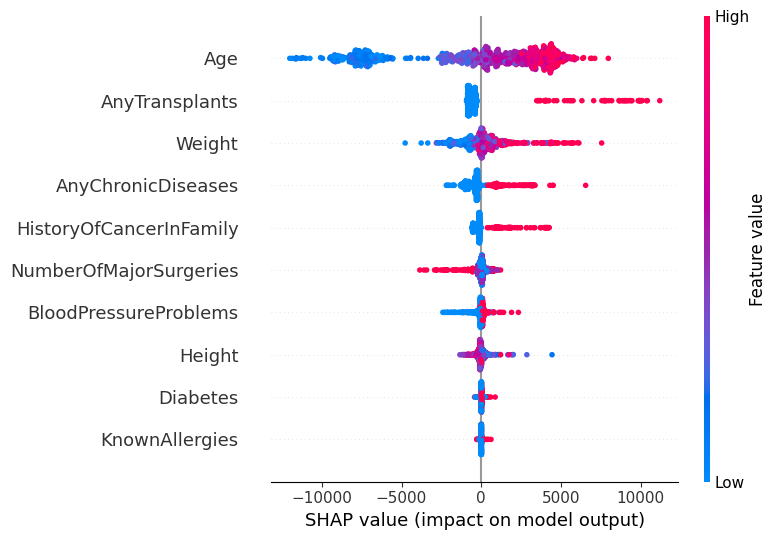

In [ ]:
shap.summary_plot(shap_values, X)

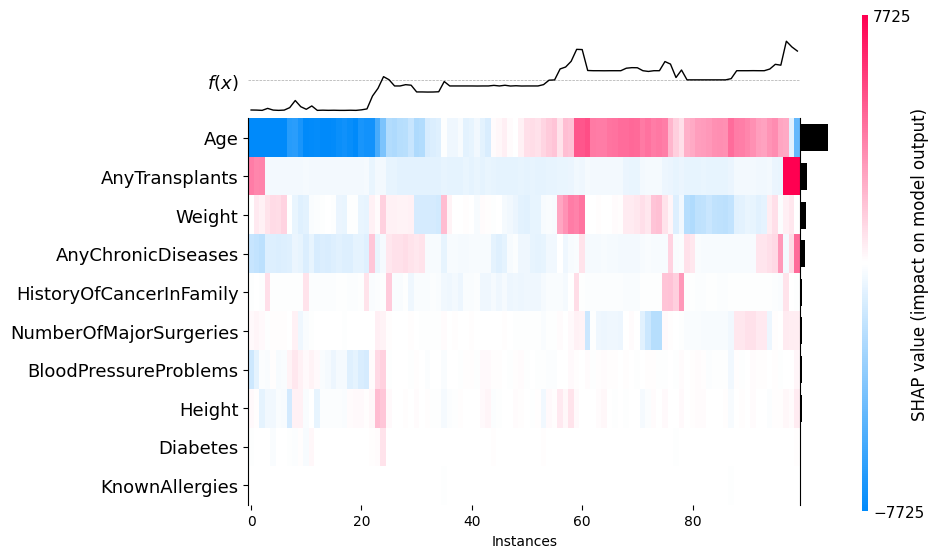

<Axes: xlabel='Instances'>

In [ ]:
shap.plots.heatmap(shap_values[:100])

In [ ]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 8.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=4526450e2dd60ceea2c925cc57dab6bd85f0bd22cf4a3e204d293db1ba56aee8
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [ ]:
def lime_feature_selection(X, y, sample_size=500):

    if isinstance(X, pd.DataFrame):
        feature_names = X.columns.tolist()
    else:
        feature_names = [f"feature_{i}" for i in range(X.shape[1])]
        X = pd.DataFrame(X, columns=feature_names)

    # Train the model
    model = RandomForestRegressor(random_state=42)
    model.fit(X, y)

    # LIME explainer
    explainer = LimeTabularExplainer(
        training_data=X.values,
        feature_names=feature_names,
        mode='regression',
        discretize_continuous=True,
        verbose=False
    )

    # Random sample of rows
    np.random.seed(42)
    indices = np.random.choice(range(X.shape[0]), size=min(sample_size, X.shape[0]), replace=False)

    # Collect importance scores
    importance_scores = defaultdict(float)
    for idx in indices:
        instance = X.iloc[idx].values

        # Wrap in DataFrame to match feature names
        instance_df = pd.DataFrame([instance], columns=feature_names)
        predict_fn = lambda x: model.predict(pd.DataFrame(x, columns=feature_names))

        # Get explanations for all features
        exp = explainer.explain_instance(instance, predict_fn, num_features=X.shape[1])
        for feature, weight in exp.as_list():
            importance_scores[feature] += abs(weight)

    # Sort feature importances (all features)
    sorted_features = sorted(importance_scores.items(), key=lambda x: x[1], reverse=True)

    return sorted_features, explainer, model  # Return all sorted features

In [ ]:
sorted_features, explainer, model = lime_feature_selection(X, y,sample_size=400)
print("Top LIME-selected features:", sorted_features)

Top LIME-selected features: [('AnyTransplants <= 0.00', 86.73058289548986), ('Age <= 30.00', 47.87090735204326), ('AnyChronicDiseases <= 0.00', 34.605327718050134), ('Age > 53.00', 26.52032035976146), ('HistoryOfCancerInFamily <= 0.00', 25.37992302715459), ('42.00 < Age <= 53.00', 18.03638185133504), ('AnyChronicDiseases > 0.00', 8.135090281125635), ('Weight > 87.00', 7.027795899229279), ('Weight <= 67.00', 6.842644526739793), ('AnyTransplants > 0.00', 6.2197552872186925), ('HistoryOfCancerInFamily > 0.00', 4.17712169391917), ('30.00 < Age <= 42.00', 3.1509079549410126), ('BloodPressureProblems <= 0.00', 2.4703551281647056), ('0.00 < BloodPressureProblems <= 1.00', 2.3571879289596116), ('KnownAllergies <= 0.00', 1.5625158609205296), ('Height <= 161.00', 1.5573983831896447), ('Diabetes <= 0.00', 1.1556167869824117), ('NumberOfMajorSurgeries <= 0.00', 1.0020074080933383), ('168.00 < Height <= 176.00', 0.8693037614940761), ('0.00 < NumberOfMajorSurgeries <= 1.00', 0.8270547244284302), ('7

In [ ]:
idx= 1
exp = explainer.explain_instance(X.iloc[idx].values, model.predict, num_features=5)
exp.show_in_notebook()
